In [13]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from cenpy.remote import APIConnection
from adjustText import adjust_text
import re

### Missouri and Oklahoma

1. Reading local Excel file 'elsec19t.xls'...
   Success! Loaded 1029 districts from 2019 Excel.
2. Fetching Shapefiles directly from Census...
   Shapefiles downloaded successfully.
3. Fetching Child Population via API (ACS 2019)...
4. Merging Data...
MO Top 5% Threshold: > $15,010
OK Top 5% Threshold: > $16,506
5. Plotting...
Done! Saved as 'tiny_district_MO_OK_boxed.png'


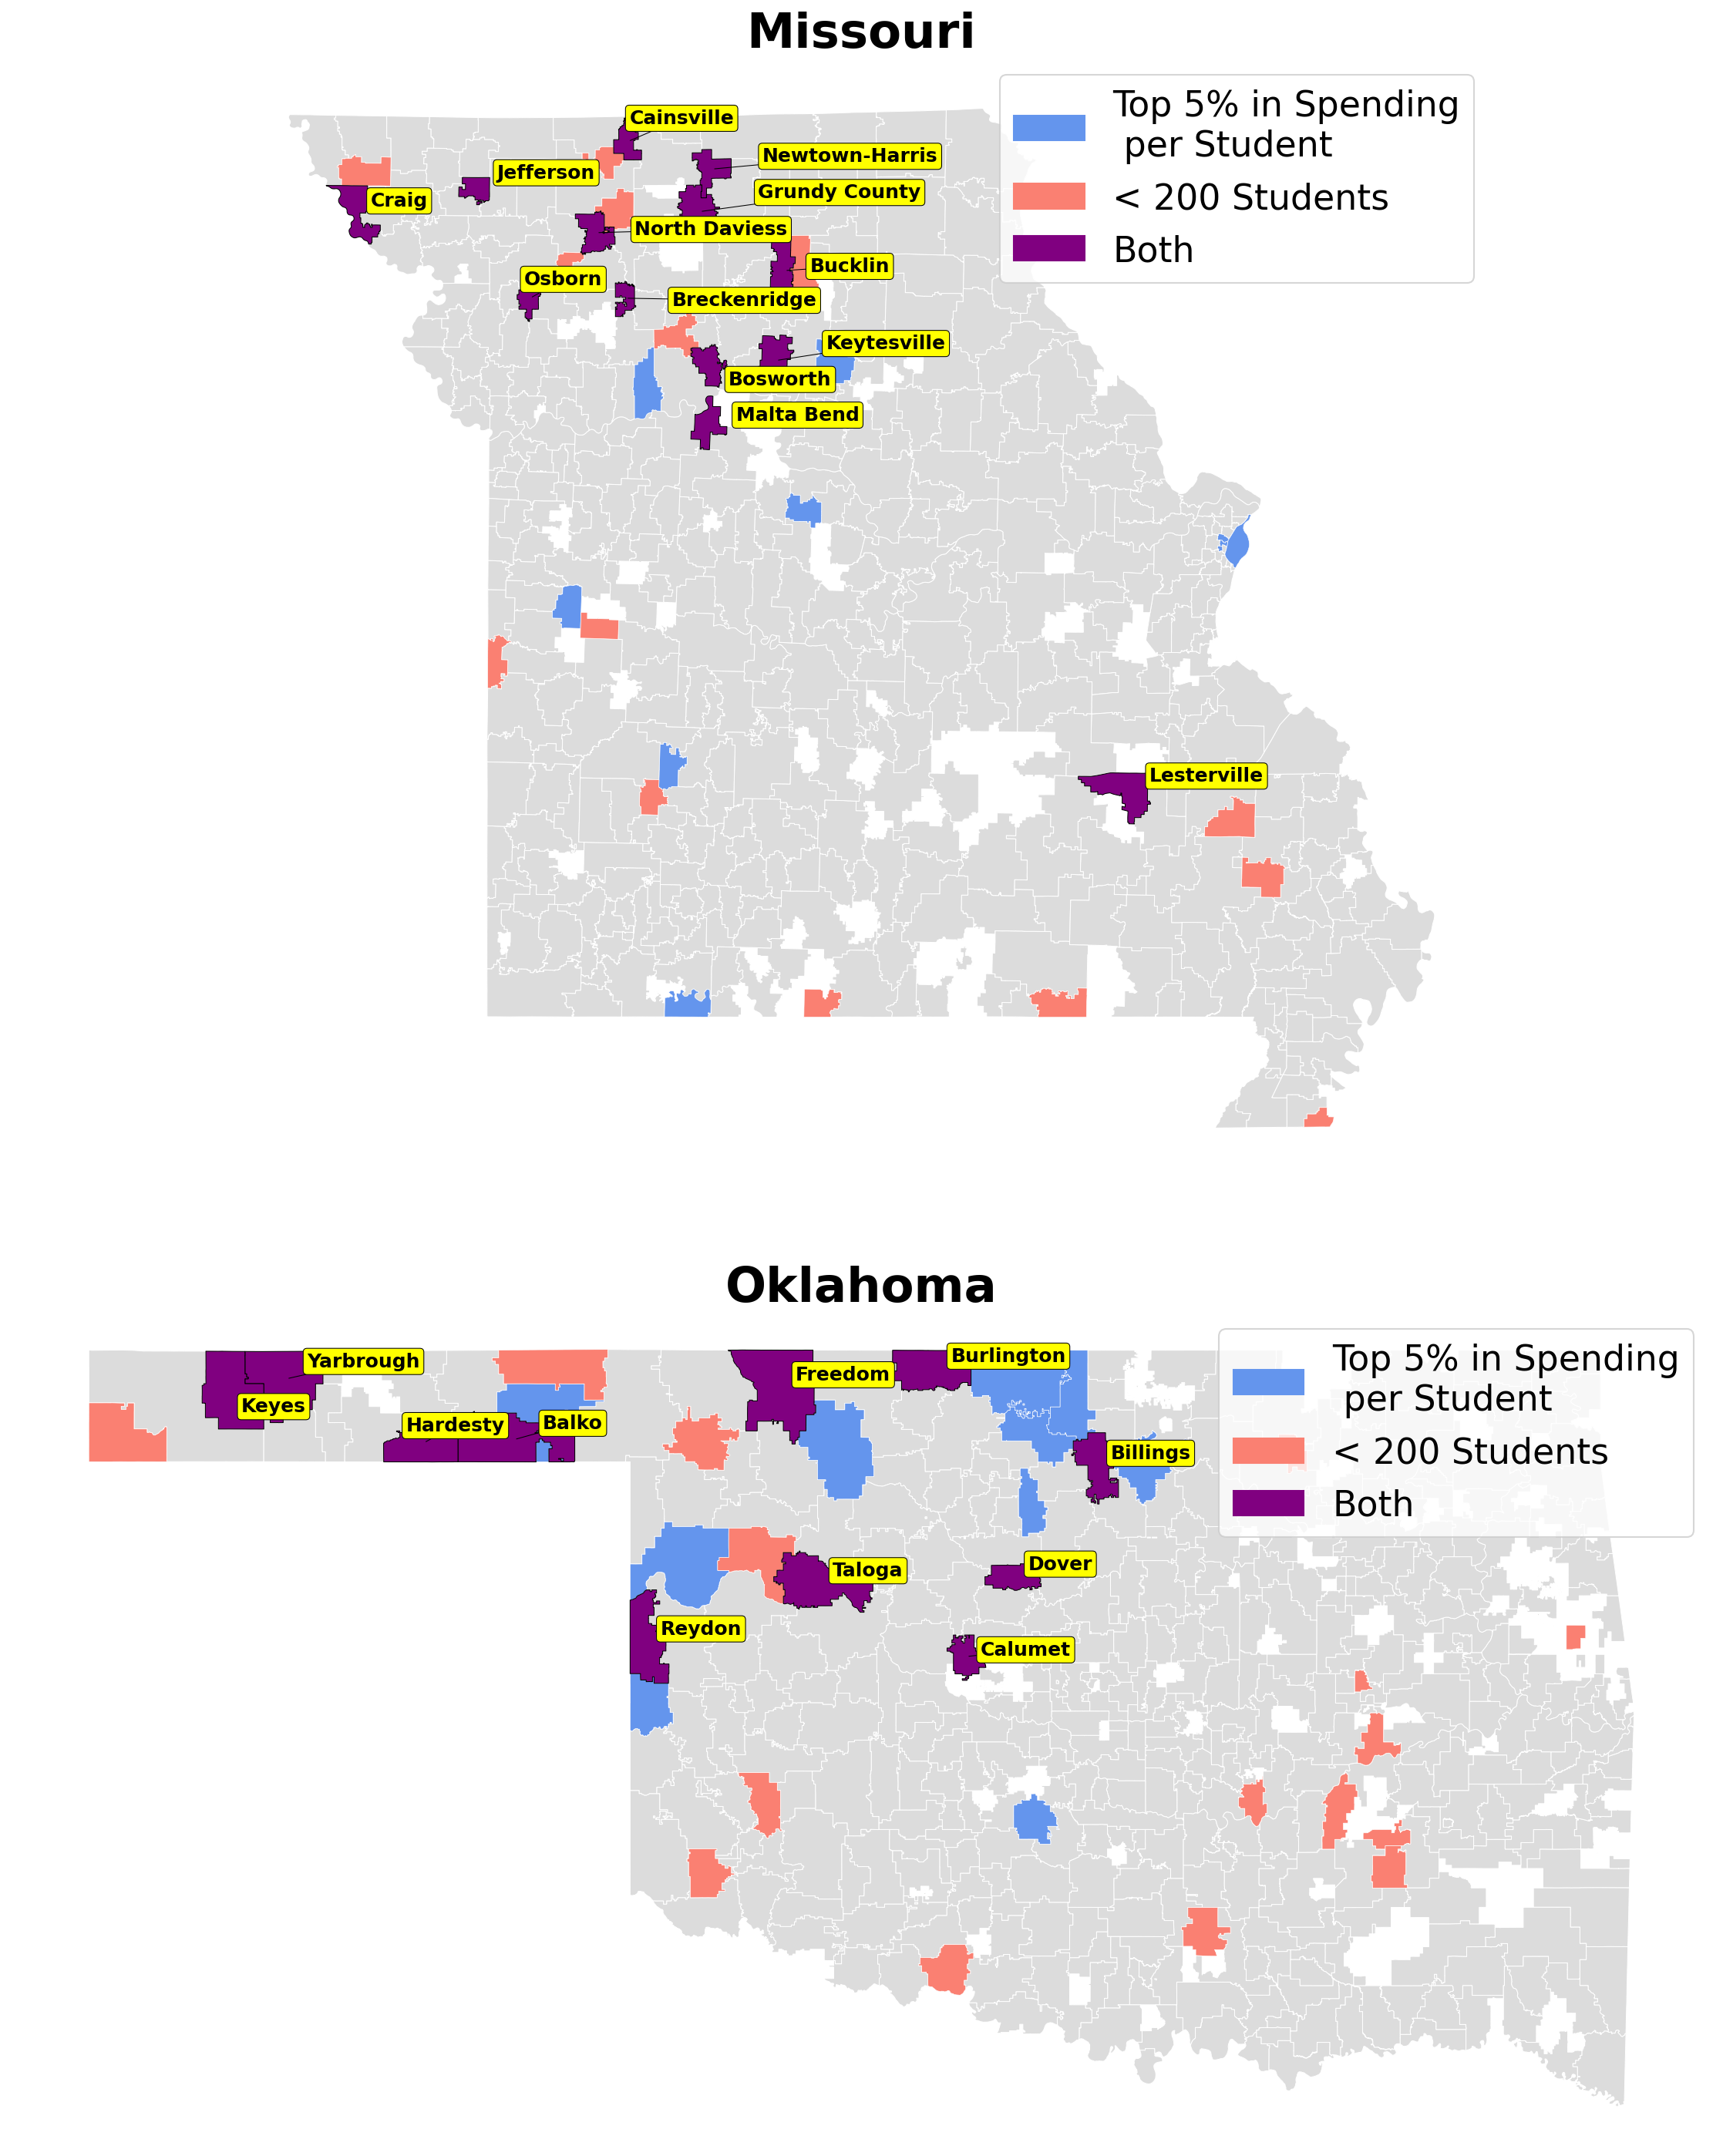

In [32]:


# --- STEP 1: LOAD MANUAL FINANCE DATA (2019 EXCEL) ---
print("1. Reading local Excel file 'elsec19t.xls'...")

try:
    # Read Excel (Standardize headers)
    df_fin = pd.read_excel('elsec19t.xls')
    df_fin.columns = df_fin.columns.str.upper().str.strip()
    
    # --- DERIVE STATE ID FROM NCESID ---
    if 'NCESID' in df_fin.columns:
        # Pad to 7 digits (e.g. 100270 -> 0100270)
        df_fin['GEOID'] = df_fin['NCESID'].astype(str).str.zfill(7)
        df_fin['STATE_EXTRACT'] = df_fin['GEOID'].str[:2]
    else:
        raise KeyError("Could not find 'NCESID' column to derive State ID.")

    # FILTER FOR MO (29) AND OK (40)
    df_mo_ok = df_fin[df_fin['STATE_EXTRACT'].isin(['29', '40'])].copy()
    
    # CLEAN SPENDING DATA
    if 'PPCSTOT' in df_mo_ok.columns:
        df_mo_ok['PPCSTOT'] = pd.to_numeric(df_mo_ok['PPCSTOT'], errors='coerce')
        df_mo_ok = df_mo_ok[df_mo_ok['PPCSTOT'] > 0]
    else:
        raise KeyError("Could not find 'PPCSTOT' column.")
    
    # KEEP ONLY ID AND MONEY
    df_mo_ok = df_mo_ok[['GEOID', 'PPCSTOT', 'STATE_EXTRACT']]
    
    print(f"   Success! Loaded {len(df_mo_ok)} districts from 2019 Excel.")

except Exception as e:
    print(f"\n!!! ERROR LOADING EXCEL: {e}")
    raise

# --- STEP 2: FETCH SHAPEFILES (DIRECTLY FROM CENSUS) ---
print("2. Fetching Shapefiles directly from Census...")
try:
    gdf_mo = gpd.read_file("https://www2.census.gov/geo/tiger/TIGER2019/UNSD/tl_2019_29_unsd.zip")
    gdf_ok = gpd.read_file("https://www2.census.gov/geo/tiger/TIGER2019/UNSD/tl_2019_40_unsd.zip")
    print("   Shapefiles downloaded successfully.")
except Exception as e:
    print(f"!!! Error downloading shapefiles: {e}")
    raise

# --- STEP 3: FETCH POPULATION (API 2019) ---
print("3. Fetching Child Population via API (ACS 2019)...")
conn_acs = APIConnection("ACSDT5Y2019")
variables = ['B09001_001E'] 

def get_acs_kids(state_fips):
    try:
        df = conn_acs.query(
            cols=variables, 
            geo_unit='school district (unified):*', 
            geo_filter={'state': state_fips}
        )
        # Create matching GEOID: state + district code
        df['GEOID'] = df['state'] + df['school district (unified)']
        df['Kids'] = df['B09001_001E'].astype(int)
        return df[['GEOID', 'Kids']]
    except Exception as e:
        print(f"   API Error for state {state_fips}: {e}")
        return pd.DataFrame()

mo_kids = get_acs_kids("29")
ok_kids = get_acs_kids("40")

# --- STEP 4: MERGE DATA ---
print("4. Merging Data...")

# Separate finance data for merging
mo_fin = df_mo_ok[df_mo_ok['STATE_EXTRACT'] == '29']
ok_fin = df_mo_ok[df_mo_ok['STATE_EXTRACT'] == '40']

def merge_and_calc(gdf, df_kids, df_fin):
    if gdf.empty or df_kids.empty or df_fin.empty:
        return gdf.copy(), 0
        
    # Merge Shapes + Kids
    m1 = gdf.merge(df_kids, on='GEOID', how='left')
    
    # Merge + Money 
    final = m1.merge(df_fin, on='GEOID', how='left')
    
    # Calculate Cutoff (Top 5%)
    if final['PPCSTOT'].notna().sum() > 0:
        cutoff = final['PPCSTOT'].quantile(0.95)
    else:
        cutoff = 0
    
    # Logic (UPDATED TO < 200 STUDENTS)
    final['is_tiny'] = (final['Kids'] < 200)
    final['is_expensive'] = (final['PPCSTOT'] > cutoff)
    final['is_both'] = final['is_tiny'] & final['is_expensive']
    
    return final, cutoff

mo_final, mo_cutoff = merge_and_calc(gdf_mo, mo_kids, mo_fin)
ok_final, ok_cutoff = merge_and_calc(gdf_ok, ok_kids, ok_fin)

print(f"MO Top 5% Threshold: > ${mo_cutoff:,.0f}")
print(f"OK Top 5% Threshold: > ${ok_cutoff:,.0f}")

# --- STEP 5: PLOTTING (REVISED LABELS & BOXES) ---
print("5. Plotting...")

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 20), dpi=150)

def plot_layer_cake(df, ax, state_name, cutoff):
    # 1. Base Map 
    df.plot(ax=ax, color='gainsboro', edgecolor='white', linewidth=0.5)
    
    # 2. Plot The Layers
    # Blue: Expensive Only
    blue = df[df['is_expensive'] & ~df['is_tiny']]
    if not blue.empty: 
        blue.plot(ax=ax, color='cornflowerblue', edgecolor='white', linewidth=0.3)
        
    # Red: Tiny Only
    red = df[df['is_tiny'] & ~df['is_expensive']]
    if not red.empty: 
        red.plot(ax=ax, color='salmon', edgecolor='white', linewidth=0.3)
        
    # Purple: BOTH 
    purple = df[df['is_both']]
    if not purple.empty: 
        purple.plot(ax=ax, color='purple', edgecolor='black', linewidth=0.5)

        # 3. Labeling Logic (Yellow Box + Clean Names)
        texts = []
        for idx, row in purple.sort_values('PPCSTOT', ascending=False).iterrows():
            centroid = row.geometry.centroid
            
            # Get raw name
            raw_name = row['NAME'] if 'NAME' in row else row.get('NAME_x', 'District')
            
            # Clean: Remove "School District", "Public Schools"
            clean_name = raw_name.replace(" School District", "").replace(" Public Schools", "")
            
            # Regex Clean: Remove "R-V", "R-III", "C-2", "R-O" etc.
            # Updated to match [RC]- followed by any combo of Roman numerals, digits, or LETTERS
            clean_name = re.sub(r'\s[RC]-[IVX0-9A-Z]+', '', clean_name)
            
            # Create text with Yellow Box
            t = ax.text(centroid.x, centroid.y, clean_name, 
                        fontsize=12, weight='bold', color='black',
                        bbox=dict(boxstyle="round,pad=0.2", fc="yellow", ec="black", lw=0.5))
            texts.append(t)
        
        # Adjust text with BLACK connecting lines
        if texts: 
            adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle='-', color='black', lw=0.5))
    
    # 4. Custom Legend
    legend_handles = [
        mpatches.Patch(color='cornflowerblue', label=f'Top 5% in Spending\n per Student'),
        mpatches.Patch(color='salmon', label='< 200 Students'),
        mpatches.Patch(color='purple', label='Both')
    ]
    
    ax.legend(handles=legend_handles, loc='upper right', frameon=True, fontsize=22)
    
    # 5. Title & formatting
    ax.set_title(state_name, fontsize=30, weight='bold')
    ax.axis('off')

# Execute plots
plot_layer_cake(mo_final, ax1, "Missouri", mo_cutoff)
plot_layer_cake(ok_final, ax2, "Oklahoma", ok_cutoff)

plt.tight_layout()
plt.savefig('tiny_district_MO_OK_boxed.png', dpi=1000, bbox_inches='tight', facecolor='white')
print("Done! Saved as 'tiny_district_MO_OK_boxed.png'")

### North Dakota and South Dakota

1. Reading local Excel file 'elsec19t.xls'...
   Success! Loaded 323 districts for ND/SD from 2019 Excel.
2. Fetching Shapefiles directly from Census...
   Shapefiles downloaded successfully.
3. Fetching Child Population via API (ACS 2019)...
4. Merging Data...
ND Top 5% Threshold: > $27,361
SD Top 5% Threshold: > $17,966
5. Plotting...
Done! Saved as 'tiny_district_ND_SD_boxed.png'


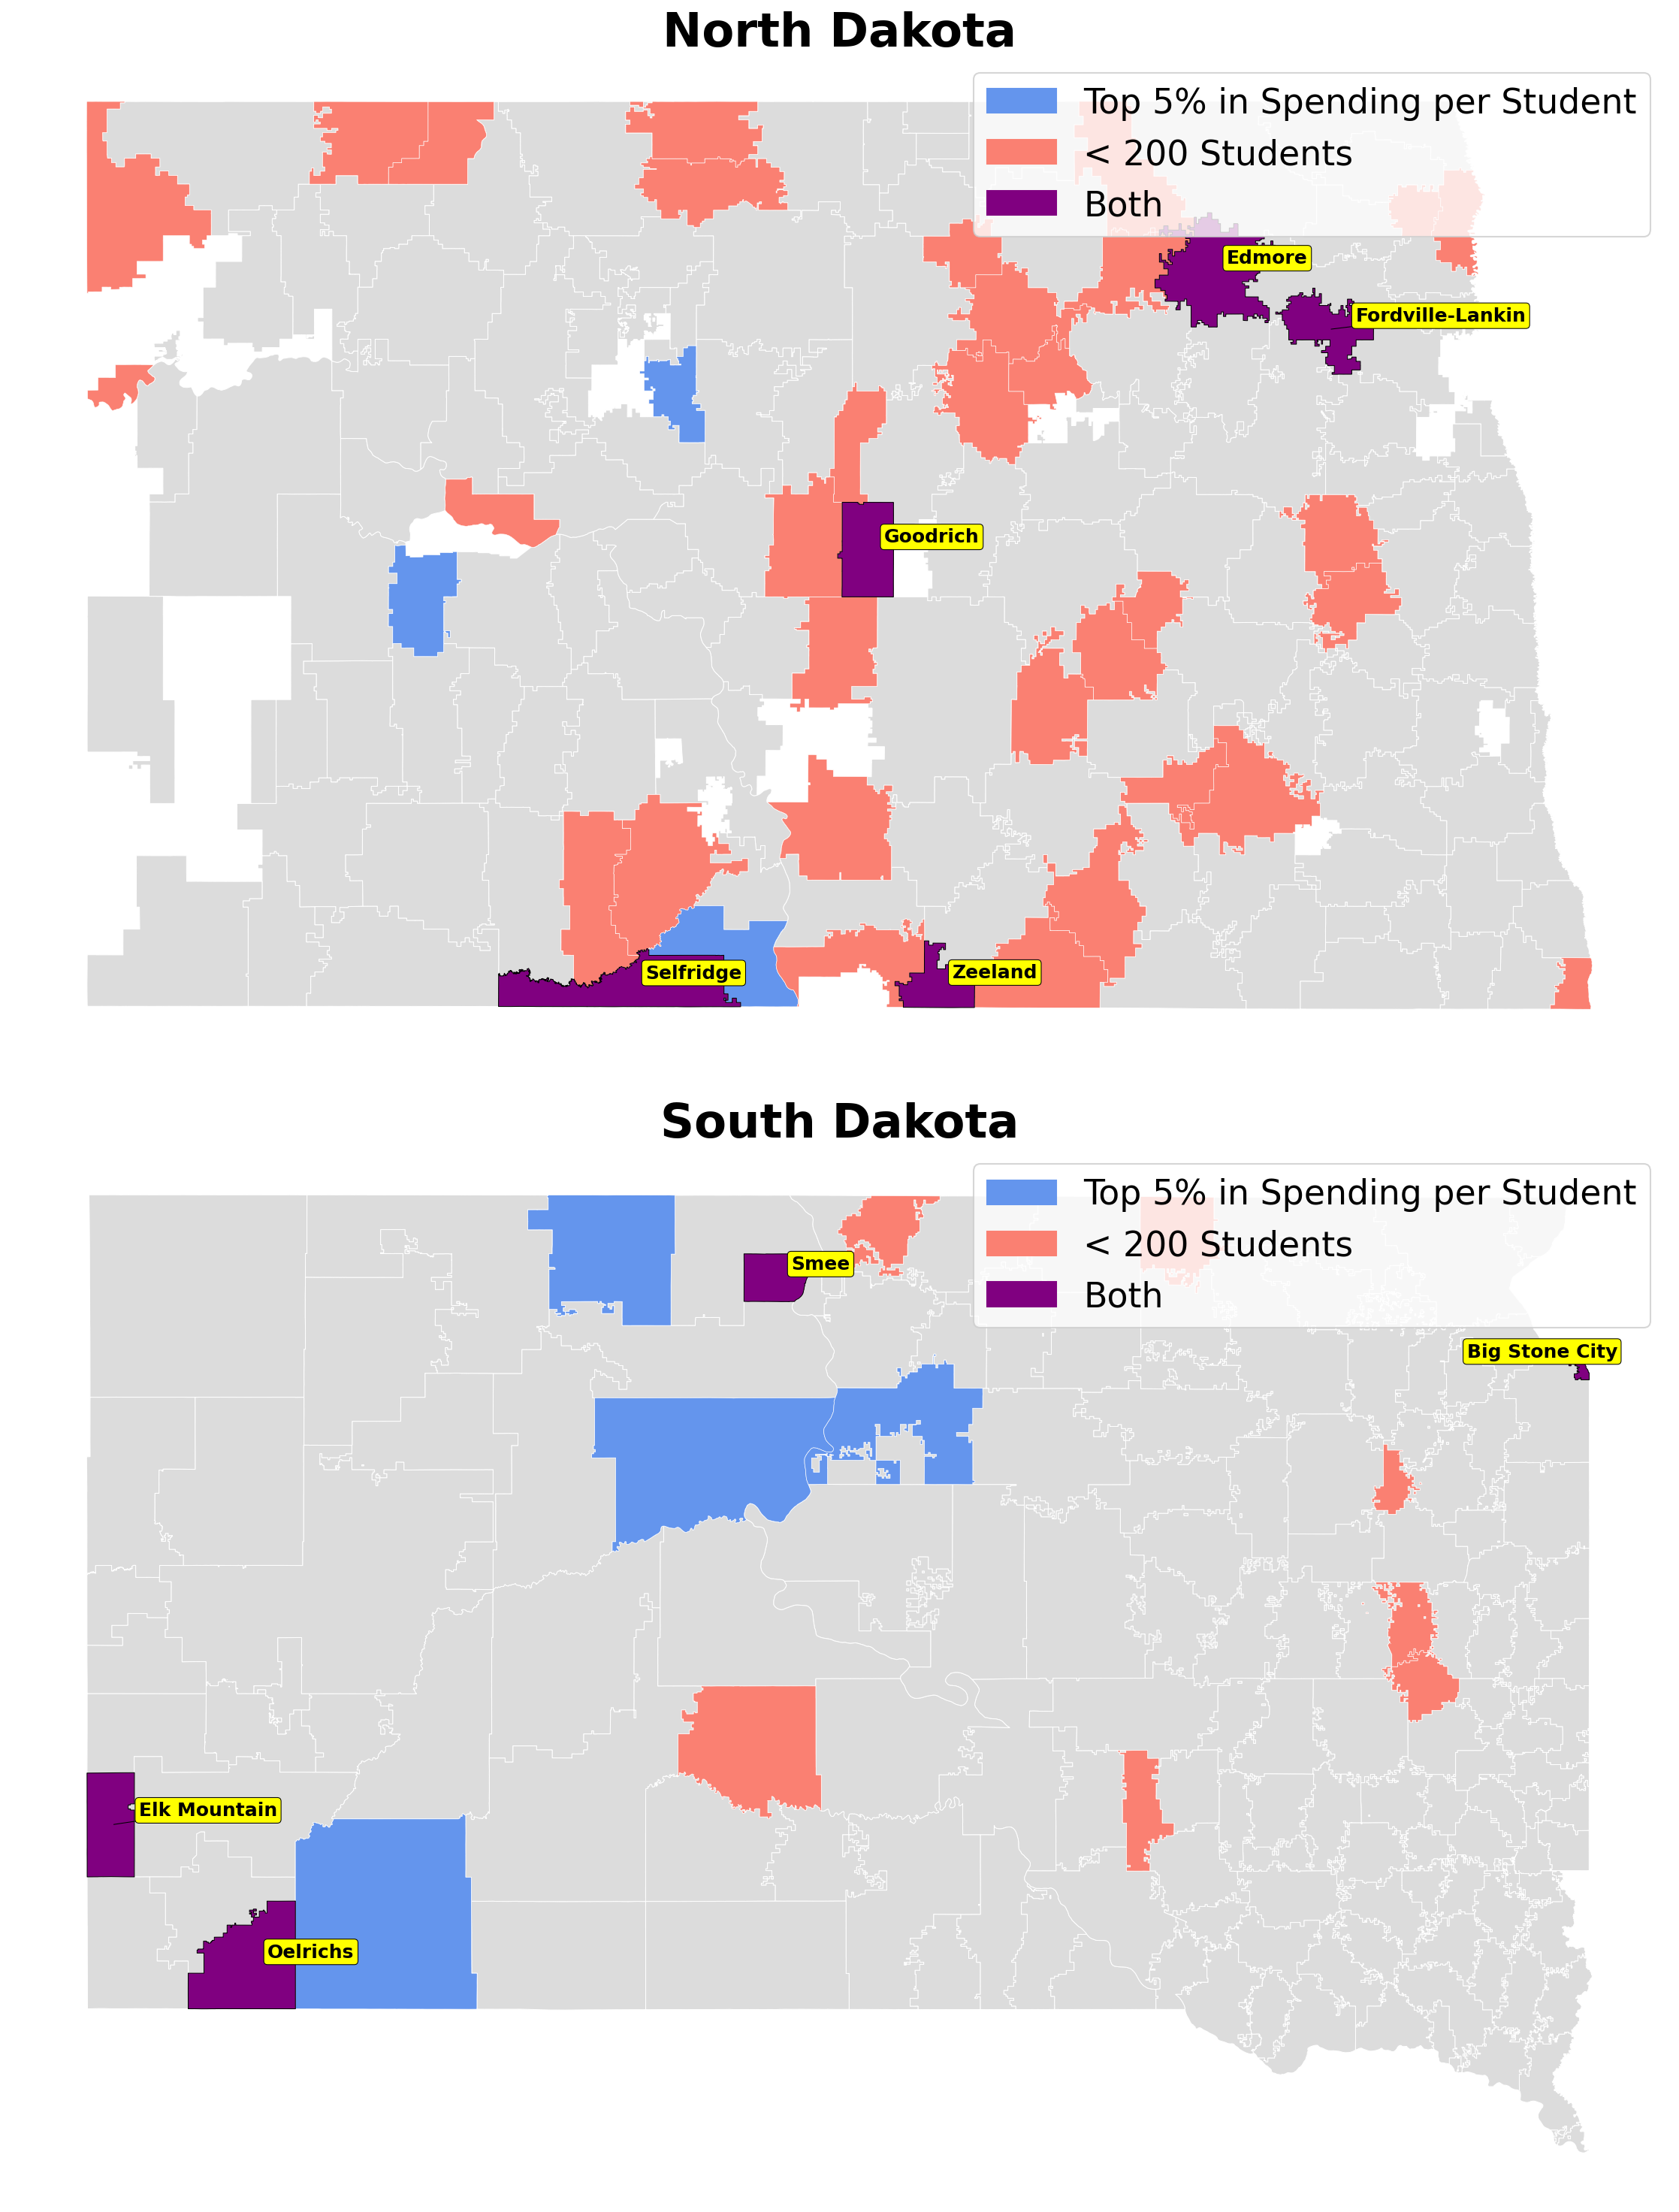

In [31]:


# --- STEP 1: LOAD MANUAL FINANCE DATA (2019 EXCEL) ---
print("1. Reading local Excel file 'elsec19t.xls'...")

try:
    # Read Excel (Standardize headers)
    df_fin = pd.read_excel('elsec19t.xls')
    df_fin.columns = df_fin.columns.str.upper().str.strip()
    
    # --- DERIVE STATE ID FROM NCESID ---
    if 'NCESID' in df_fin.columns:
        # Pad to 7 digits (e.g. 100270 -> 0100270)
        df_fin['GEOID'] = df_fin['NCESID'].astype(str).str.zfill(7)
        df_fin['STATE_EXTRACT'] = df_fin['GEOID'].str[:2]
    else:
        raise KeyError("Could not find 'NCESID' column to derive State ID.")

    # FILTER FOR ND (38) AND SD (46)
    df_nd_sd = df_fin[df_fin['STATE_EXTRACT'].isin(['38', '46'])].copy()
    
    # CLEAN SPENDING DATA
    if 'PPCSTOT' in df_nd_sd.columns:
        df_nd_sd['PPCSTOT'] = pd.to_numeric(df_nd_sd['PPCSTOT'], errors='coerce')
        df_nd_sd = df_nd_sd[df_nd_sd['PPCSTOT'] > 0]
    else:
        raise KeyError("Could not find 'PPCSTOT' column.")
    
    # KEEP ONLY ID AND MONEY
    df_nd_sd = df_nd_sd[['GEOID', 'PPCSTOT', 'STATE_EXTRACT']]
    
    print(f"   Success! Loaded {len(df_nd_sd)} districts for ND/SD from 2019 Excel.")

except Exception as e:
    print(f"\n!!! ERROR LOADING EXCEL: {e}")
    raise

# --- STEP 2: FETCH SHAPEFILES (DIRECTLY FROM CENSUS) ---
print("2. Fetching Shapefiles directly from Census...")
try:
    # FIPS 38 = North Dakota, 46 = South Dakota
    gdf_nd = gpd.read_file("https://www2.census.gov/geo/tiger/TIGER2019/UNSD/tl_2019_38_unsd.zip")
    gdf_sd = gpd.read_file("https://www2.census.gov/geo/tiger/TIGER2019/UNSD/tl_2019_46_unsd.zip")
    print("   Shapefiles downloaded successfully.")
except Exception as e:
    print(f"!!! Error downloading shapefiles: {e}")
    raise

# --- STEP 3: FETCH POPULATION (API 2019) ---
print("3. Fetching Child Population via API (ACS 2019)...")
conn_acs = APIConnection("ACSDT5Y2019")
variables = ['B09001_001E'] 

def get_acs_kids(state_fips):
    try:
        df = conn_acs.query(
            cols=variables, 
            geo_unit='school district (unified):*', 
            geo_filter={'state': state_fips}
        )
        # Create matching GEOID: state + district code
        df['GEOID'] = df['state'] + df['school district (unified)']
        df['Kids'] = df['B09001_001E'].astype(int)
        return df[['GEOID', 'Kids']]
    except Exception as e:
        print(f"   API Error for state {state_fips}: {e}")
        return pd.DataFrame()

# Fetch ND (38) and SD (46)
nd_kids = get_acs_kids("38")
sd_kids = get_acs_kids("46")

# --- STEP 4: MERGE DATA ---
print("4. Merging Data...")

# Separate finance data for merging
nd_fin = df_nd_sd[df_nd_sd['STATE_EXTRACT'] == '38']
sd_fin = df_nd_sd[df_nd_sd['STATE_EXTRACT'] == '46']

def merge_and_calc(gdf, df_kids, df_fin):
    if gdf.empty or df_kids.empty or df_fin.empty:
        return gdf.copy(), 0
        
    # Merge Shapes + Kids
    m1 = gdf.merge(df_kids, on='GEOID', how='left')
    
    # Merge + Money 
    final = m1.merge(df_fin, on='GEOID', how='left')
    
    # Calculate Cutoff (Top 5%)
    if final['PPCSTOT'].notna().sum() > 0:
        cutoff = final['PPCSTOT'].quantile(0.95)
    else:
        cutoff = 0
    
    # Logic (KEPT AT < 200 STUDENTS)
    final['is_tiny'] = (final['Kids'] < 200)
    final['is_expensive'] = (final['PPCSTOT'] > cutoff)
    final['is_both'] = final['is_tiny'] & final['is_expensive']
    
    return final, cutoff

nd_final, nd_cutoff = merge_and_calc(gdf_nd, nd_kids, nd_fin)
sd_final, sd_cutoff = merge_and_calc(gdf_sd, sd_kids, sd_fin)

print(f"ND Top 5% Threshold: > ${nd_cutoff:,.0f}")
print(f"SD Top 5% Threshold: > ${sd_cutoff:,.0f}")

# --- STEP 5: PLOTTING (REVISED LABELS & BOXES) ---
print("5. Plotting...")

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 20), dpi=150)

def plot_layer_cake(df, ax, state_name, cutoff):
    # 1. Base Map 
    df.plot(ax=ax, color='gainsboro', edgecolor='white', linewidth=0.5)
    
    # 2. Plot The Layers
    # Blue: Expensive Only
    blue = df[df['is_expensive'] & ~df['is_tiny']]
    if not blue.empty: 
        blue.plot(ax=ax, color='cornflowerblue', edgecolor='white', linewidth=0.3)
        
    # Red: Tiny Only
    red = df[df['is_tiny'] & ~df['is_expensive']]
    if not red.empty: 
        red.plot(ax=ax, color='salmon', edgecolor='white', linewidth=0.3)
        
    # Purple: BOTH 
    purple = df[df['is_both']]
    if not purple.empty: 
        purple.plot(ax=ax, color='purple', edgecolor='black', linewidth=0.5)

        # 3. Labeling Logic (Yellow Box + Clean Names)
        texts = []
        for idx, row in purple.sort_values('PPCSTOT', ascending=False).iterrows():
            centroid = row.geometry.centroid
            
            # Get raw name
            raw_name = row['NAME'] if 'NAME' in row else row.get('NAME_x', 'District')
            
            # Clean: Remove "School District", "Public Schools", "Public School"
            clean_name = raw_name.replace(" School District", "").replace(" Public Schools", "").replace(" Public School", "")
            
            # Regex Clean: Remove "Public 4" or "51-4"
            # 1. Remove "Public" followed by digits (e.g. "Fargo Public 1" -> "Fargo")
            clean_name = re.sub(r'\sPublic\s\d+', '', clean_name)
            
            # 2. Remove Hyphenated numbers at end (e.g. "Rapid City 51-4" -> "Rapid City")
            clean_name = re.sub(r'\s\d+-\d+', '', clean_name)
            
            # 3. Remove standalone numbers at end (e.g. "Valley City 2" -> "Valley City")
            # clean_name = re.sub(r'\s\d+$', '', clean_name) # UNCOMMENT IF YOU WANT THIS TOO
            
            # Create text with Yellow Box
            t = ax.text(centroid.x, centroid.y, clean_name, 
                        fontsize=12, weight='bold', color='black',
                        bbox=dict(boxstyle="round,pad=0.2", fc="yellow", ec="black", lw=0.5))
            texts.append(t)
        
        # Adjust text with BLACK connecting lines
        if texts: 
            adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle='-', color='black', lw=0.5))
    
    # 4. Custom Legend
    legend_handles = [
        mpatches.Patch(color='cornflowerblue', label=f'Top 5% in Spending per Student'),
        mpatches.Patch(color='salmon', label='< 200 Students'),
        mpatches.Patch(color='purple', label='Both')
    ]
    
    ax.legend(handles=legend_handles, loc='upper right', frameon=True, fontsize=22)
    
    # 5. Title & formatting
    ax.set_title(state_name, fontsize=30, weight='bold')
    ax.axis('off')

# Execute plots
plot_layer_cake(nd_final, ax1, "North Dakota", nd_cutoff)
plot_layer_cake(sd_final, ax2, "South Dakota", sd_cutoff)

plt.tight_layout()
plt.savefig('tiny_district_ND_SD_boxed.png', dpi=1000, bbox_inches='tight', facecolor='white')
print("Done! Saved as 'tiny_district_ND_SD_boxed.png'")

### Validation

In [21]:


# --- CONFIGURATION ---
states_to_check = {
    'Missouri': '29',
    'Oklahoma': '40',
    'North Dakota': '38',
    'South Dakota': '46'
}

print("--- STARTING FACT CHECK FOR 4 STATES ---\n")

# 1. LOAD FINANCE DATA (Once for all states)
print("1. Loading Finance Data (Excel)...")
try:
    df_fin = pd.read_excel('elsec19t.xls')
    df_fin.columns = df_fin.columns.str.upper().str.strip()
    if 'NCESID' in df_fin.columns:
        df_fin['GEOID'] = df_fin['NCESID'].astype(str).str.zfill(7)
        df_fin['STATE_EXTRACT'] = df_fin['GEOID'].str[:2]
        
    # Clean Spending Column
    df_fin['PPCSTOT'] = pd.to_numeric(df_fin['PPCSTOT'], errors='coerce')
    df_fin = df_fin[df_fin['PPCSTOT'] > 0]
    print(f"   Success. Loaded {len(df_fin)} total records.\n")
except Exception as e:
    print(f"!!! CRITICAL ERROR: {e}")
    raise

# 2. SETUP API FOR KIDS
conn_acs = APIConnection("ACSDT5Y2019")

# --- MAIN LOOP ---
for state_name, fips in states_to_check.items():
    print(f"--- ANALYZING {state_name.upper()} (FIPS {fips}) ---")
    
    # A. Fetch Kids
    try:
        df_kids = conn_acs.query(
            cols=['B09001_001E'], 
            geo_unit='school district (unified):*', 
            geo_filter={'state': fips}
        )
        df_kids['GEOID'] = df_kids['state'] + df_kids['school district (unified)']
        df_kids['Kids'] = df_kids['B09001_001E'].astype(int)
    except Exception as e:
        print(f"   ! Error fetching population: {e}")
        continue

    # B. Fetch Shapes (Needed to get the official 'NAME' for the district)
    try:
        url = f"https://www2.census.gov/geo/tiger/TIGER2019/UNSD/tl_2019_{fips}_unsd.zip"
        gdf = gpd.read_file(url)
    except Exception as e:
        print(f"   ! Error fetching shapes: {e}")
        continue

    # C. Merge
    # Filter finance for just this state
    state_fin = df_fin[df_fin['STATE_EXTRACT'] == fips].copy()
    
    # Merge Kids + Shapes + Money
    merged = gdf.merge(df_kids[['GEOID', 'Kids']], on='GEOID', how='left')
    final = merged.merge(state_fin[['GEOID', 'PPCSTOT']], on='GEOID', how='left')
    
    # D. Calculate Logic
    cutoff = final['PPCSTOT'].quantile(0.95)
    final['is_tiny'] = (final['Kids'] < 200)
    final['is_expensive'] = (final['PPCSTOT'] > cutoff)
    final['is_both'] = final['is_tiny'] & final['is_expensive']
    
    # E. Extract "Purple" Districts
    purple_districts = final[final['is_both']].copy()
    
    if purple_districts.empty:
        print("   No districts met both criteria (Tiny + Expensive).")
    else:
        # Sort by most expensive
        purple_districts = purple_districts.sort_values('PPCSTOT', ascending=False)
        
        print(f"   Found {len(purple_districts)} 'Purple' districts (Top 5% Cost + <200 Kids).")
        print(f"   Spending Threshold (Top 5%): > ${cutoff:,.0f}")
        print("\n   TOP 10 MOST EXPENSIVE TINY DISTRICTS:")
        print(f"   {'DISTRICT NAME':<35} | {'KIDS':<5} | {'SPENDING':<10}")
        print("   " + "-"*60)
        
        for idx, row in purple_districts.head(10).iterrows():
            # Apply the cleaning logic to the name for readability
            raw_name = row['NAME']
            clean = raw_name.replace(" School District", "").replace(" Public Schools", "").replace(" Public School", "")
            clean = re.sub(r'\s[RC]-[IVX0-9]+', '', clean) # MO style
            clean = re.sub(r'\sPublic\s\d+', '', clean)     # ND style
            clean = re.sub(r'\s\d+-\d+', '', clean)         # SD style
            
            print(f"   {clean:<35} | {row['Kids']:<5} | ${row['PPCSTOT']:,.0f}")
    
    print("\n")

--- STARTING FACT CHECK FOR 4 STATES ---

1. Loading Finance Data (Excel)...
   Success. Loaded 13269 total records.

--- ANALYZING MISSOURI (FIPS 29) ---
   Found 13 'Purple' districts (Top 5% Cost + <200 Kids).
   Spending Threshold (Top 5%): > $15,010

   TOP 10 MOST EXPENSIVE TINY DISTRICTS:
   DISTRICT NAME                       | KIDS  | SPENDING  
   ------------------------------------------------------------
   Bosworth                            | 50    | $30,609
   North Daviess                       | 132   | $21,955
   Newtown-Harris                      | 119   | $20,975
   Craig                               | 107   | $20,081
   Breckenridge                        | 90    | $20,034
   Malta Bend                          | 78    | $19,578
   Osborn R-O                          | 179   | $19,343
   Cainsville                          | 79    | $19,038
   Grundy County                       | 181   | $18,484
   Lesterville                         | 189   | $17,665


--- ANA